<a href="https://colab.research.google.com/github/claude-hamou/claude-hamou/blob/main/media_mix_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Media Mix Modeling: US - iOS 

## Scope

The scope of the prototyping is the same as the one of the first iteration: 
* US
* ios
* Only the major netowkrs (Facebook, Pinterest, ASA, UAC, Twitter). 

Also based on the results of the first iteration, the focus of this one is:
* Weekly sales (not daily - and not installs)
* Data since beginning of 2019
* Focus on Log-Log (linear) models

THe objective is to reach an R Squared of 80% 

## Packages & Code Style Checker¶

In [1]:
#!pip install "ipython>=7"

In [2]:

# Uncomment this to check the code against PEP8 coding style
#%load_ext pycodestyle_magic
#%pycodestyle_on


In [3]:
import os
import numpy as np
import datetime as dt
from google.cloud import bigquery
import pandas as pd
import statsmodels
import statsmodels.formula.api as sm
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Parameters

In [4]:
bq_project = "thefabulousco-data-prod"
bq_dataset = "user_acquisition"
bq_location = "EU"
bq_table = 'performance'
user_creation_time_days = 100

In [5]:
platform = 'ios'
country = 'US'
networks = ['Organic', 'Facebook', 'Twitter Installs', 'Adwords UAC Installs', 'Pinterest']
# target_variable = 'sales'
# dt.date.today() - dt.timedelta(days=user_creation_time_days)
start_date = dt.date(2019, 1, 1)
# end_date = dt.date.today() - dt.timedelta(days=8)

In [6]:
from google.colab import auth
auth.authenticate_user()
client = bigquery.Client(project=bq_project) #  Initialise a BigQuery client

## Data Collection

In [7]:
# Sql Query to collect the data from BigQuery
sql = """
    select
        extract(year from date) as year,
        extract(week from date) as week,
        min(date) as date,
        count(distinct date) as number_days,
        sum(sales) as sales,
        sum(case when network = 'Facebook' then spend else 0 end) as facebook,
        sum(case when network = 'Twitter Installs' then spend else 0 end) as twitter,
        sum(case when network = 'Adwords UAC Installs' then spend else 0 end) as adwords,
        sum(case when network = 'Apple Search Ads' then spend else 0 end) as asa,
        sum(case when network = 'Pinterest' then spend else 0 end) as pinterest,
        sum(case when network not in ('{}') then spend else 0 end) as rest
    from
        `{}.{}.{}`
    where 1=1 -- just to have all filter with the same indentation
        and platform = '{}'
        and country = '{}'
        and date >= '2019-01-01'
        and extract(week from date) > 1 and EXTRACT(week from date) < 51
        -- The last filter is to exclude end of year last of year data which is highly impacted by seasonality
    group by 1,2
    having number_days = 7
    order by 3 desc
""".format(
    "','".join(networks),    
    bq_project,
    bq_dataset,
    bq_table,
    platform,
    country
)

In [8]:
# Collect and prepare the data
df_dbt = client.query(sql).to_dataframe()
df_dbt.drop(['year', 'week', 'number_days'], axis=1, inplace=True)
df_dbt['date'] = pd.to_datetime(df_dbt['date'])

In [27]:
df_dbt.head()

,date,sales,facebook,twitter,adwords,asa,pinterest,rest
0,2021-04-11,2240.0,17076.802839,1963.148351,0.0,1154.1286,1835.200770,4801.2686
1,2021-04-04,6283.0,28165.666182,1010.293755,0.0,1265.9074,11612.485880,5492.8674
2,2021-03-28,4901.0,31982.042138,151.975548,0.0,1451.5191,6627.576231,5317.9891
3,2021-03-21,5934.0,28719.234191,137.274051,0.0,1282.5929,8113.624223,2953.4829
4,2021-03-14,5230.0,28095.060545,150.689282,0.0,1158.1158,6472.727916,3163.6458


## Model Building

In [10]:
df_train = df_dbt[(df_dbt['date'] >= pd.to_datetime('2019-01-01')) &
                  (df_dbt['date'] < pd.to_datetime('2020-07-01'))]
df_test = df_dbt[(df_dbt['date'] >= pd.to_datetime('2020-07-01')) &
                 (df_dbt['date'] <= pd.to_datetime('2021-01-31'))]

In [11]:
print(df_train.shape, df_test.shape)

(74, 8) (28, 8)


In [12]:
model_sales = sm.ols(
    formula="np.log1p(sales) ~ np.log1p(facebook) + \
                              np.log1p(twitter) + \
                              np.log1p(pinterest) + \
                              np.log1p(adwords) + \
                              np.log1p(asa) + \
                              np.log1p(rest)",
    data=df_train
).fit()

In [13]:
beta = model_sales.params
beta

# The beta coefficient for adwords is strictly negative where it should be 
# between 0 and 1.

# It seems that facebook has a huge sensitivity, such as, to a lesser extent,
# twitter and pinterest. The other channels have relatively a sensitivity
# of 0.

Intercept              4.203188
np.log1p(facebook)     0.263604
np.log1p(twitter)      0.107193
np.log1p(pinterest)    0.045315
np.log1p(adwords)     -0.000526
np.log1p(asa)          0.000000
np.log1p(rest)         0.000000
dtype: float64

## Model Evaluation

### Helping Functions

In [14]:
def actual_vs_prediction(df, model, predictors=['facebook',
                                                'twitter',
                                                'pinterest',
                                                'adwords',
                                                'asa',
                                                'rest']):
    df_prediction = pd.DataFrame(
        {'Actual': df['sales'],
         'Predicted': np.expm1(model.predict(df[predictors]))}
    ).set_index(df['date'])
    return df_prediction

In [15]:
def calculate_deviation(x, y):
    return 100*(y-x)/x

In [16]:
def plot_charts(df, title):
    # plot 1: Sales time series (Prediction vs Actual)
    figure(num=None, figsize=(30, 9), dpi=250, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    plt.plot(df['Actual'], label='Actual')
    plt.plot(df['Predicted'], label='Predicted')
    plt.title(title)
    plt.legend()

    # Chart 2: Prediction deviation
    plt.subplot(1, 2, 2)
    df['deviation_percentage'].hist()

    plt.show()

### Explained Varaince: R-Squared

In [17]:
model_sales.rsquared  # 0.6703170512433299, the model is not significant enough.
                      # This may be related to the absence of regularization and
                      # decay in the variables.

0.6734330223414131

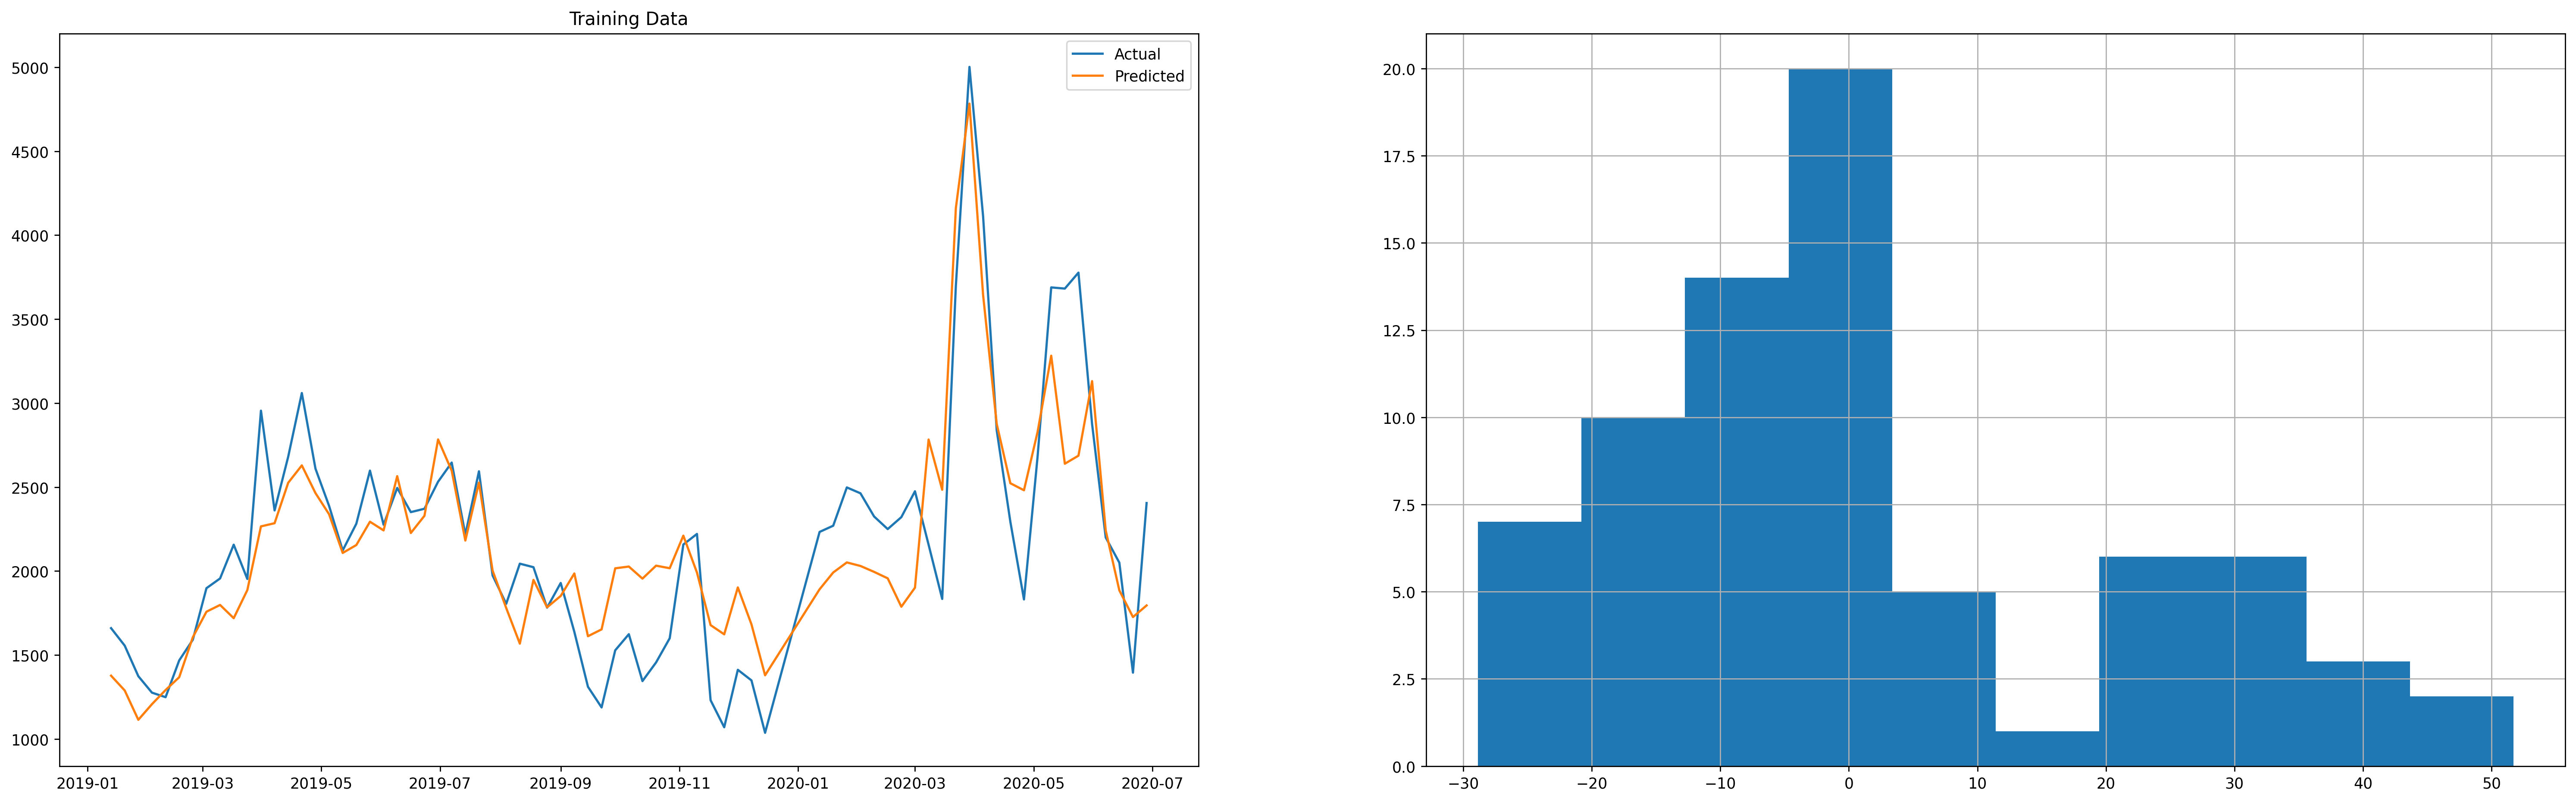

In [18]:
# Training Data
df_train_prediction = actual_vs_prediction(df_train, model_sales)
df_train_prediction['deviation_percentage'] = df_train_prediction.apply(
    lambda row: calculate_deviation(row['Actual'], row['Predicted']), axis=1)

plot_charts(df_train_prediction, 'Training Data')

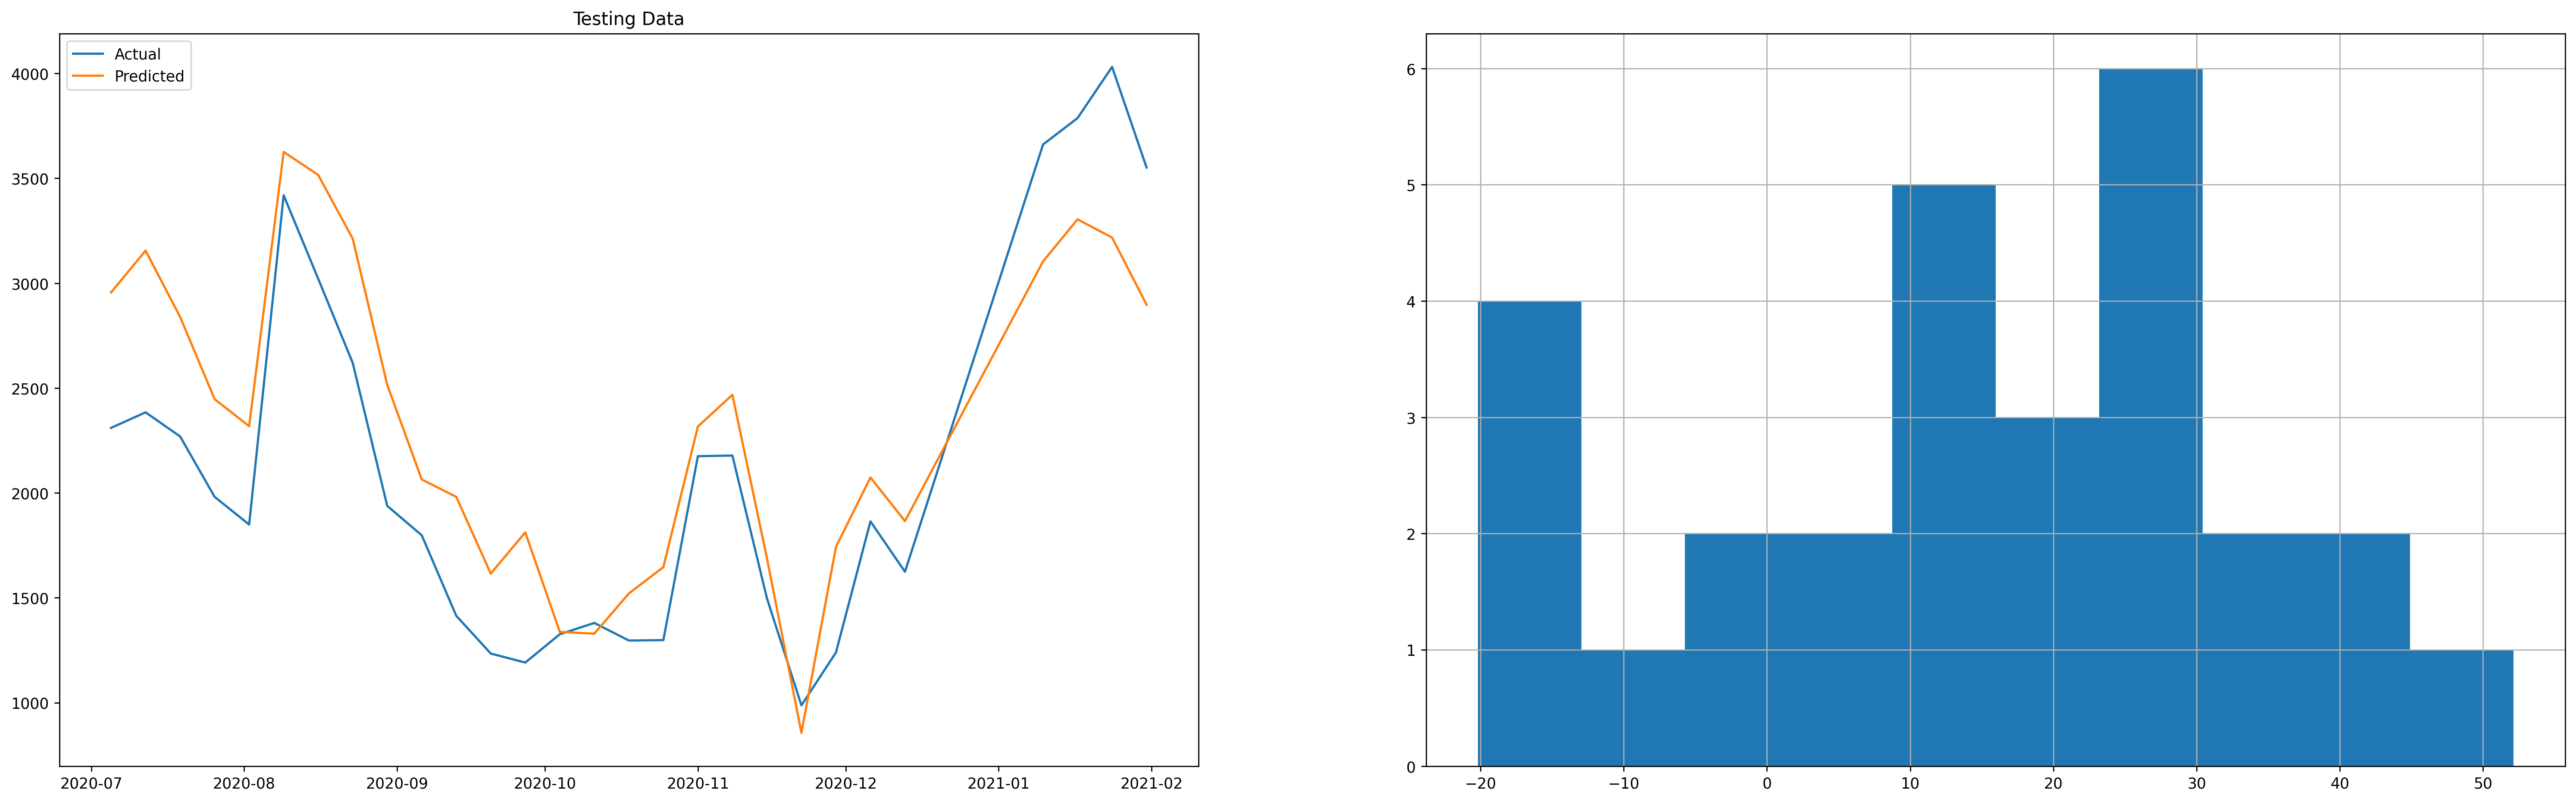

In [19]:
# Testing Data
df_test_prediction = actual_vs_prediction(df_test, model_sales)
df_test_prediction['deviation_percentage'] = df_test_prediction.apply(
    lambda row: calculate_deviation(row['Actual'], row['Predicted']), axis=1)

plot_charts(df_test_prediction, 'Testing Data')

## Some Conclusions

* Q4-2019 and Q1-2020 were difficult to model
* Generally speaking 2020 was tricky to model because of how Corona impacted the market
* 70% for R-Squared is not enough to have accuracte estimates for all networks
* That being said, organic and the bigger ones like Facebook should be ok
* The model clearly struggles with smaller networks
* What is missing here is to evaluate how well the model properly allocates sales between different networks. This could be done using the model coefficients and the data we measured using click based attribution

# Evaluation per network

Now that we drew conclusions about the model and its relation to all the networks mentioned at the same time, we want to evaluate the model with respect to each network, separately.

In order to do this, we are going to compute the estimated sales per network with our model, and compare it the the actual number of sales per network (that we have from another table, amplitude_sales). 

This comparison will be especially shown through the computation of the ROAS per week per network, that we will plot.



In [28]:
def estimated_sales_per_network(network, df):
    i = list(df.columns).index(network) - 1
    return(np.expm1(beta[0] + beta[i]*np.log1p(df[network])))

print(estimated_sales_per_network('facebook', df_train))

38     644.194787
39     654.300207
40     635.751685
41     634.694826
42     837.073568
          ...    
107    634.497140
108    545.065533
109    522.546552
110    590.053148
111    613.326800
Name: facebook, Length: 74, dtype: float64


In [21]:
# Collecting the actual number of sales per week per network from 
# 'amplitude_sales'.

bq_amplitude = 'amplitude_sales'

new_sql = """
    select
        extract(year from event_time) as year,
        extract(week from event_time) as week,
        min(extract(date from event_time)) as date,
        count(distinct extract(date from event_time)) as number_days,
        avg(amount) as avg_price,
        sum(case when network = 'Facebook' then 1 else 0 end) as facebook_sales,
        sum(case when network = 'Twitter Installs' then 1 else 0 end) as twitter_sales,
        sum(case when network = 'Adwords UAC Installs' then 1 else 0 end) as adwords_sales,
        sum(case when network = 'Apple Search Ads' then 1 else 0 end) as asa_sales,
        sum(case when network = 'Pinterest' then 1 else 0 end) as pinterest_sales,
        sum(case when network not in ('{}') then 1 else 0 end) as rest_sales
    from
        `{}.{}.{}`
    where 1=1 -- just to have all filter with the same indentation
        and platform = '{}'
        and country = '{}'
        and extract(date from event_time) >= '2019-01-01'
        and extract(week from event_time) > 1 and EXTRACT(week from event_time) < 51
        -- The last filter is to exclude end of year last of year data which is highly impacted by seasonality
    group by 1,2
    having number_days = 7
    order by 3 desc
""".format(   
    "','".join(networks),
    bq_project,
    bq_dataset,
    bq_amplitude,
    platform,
    country
)

In [22]:
# Building the dataset on the same time scale than the train dataset

df_dbt_new = client.query(new_sql).to_dataframe()
df_dbt_new.drop(['year', 'week', 'number_days'], axis=1, inplace=True)
df_dbt_new['date'] = pd.to_datetime(df_dbt_new['date'])
df_train_avg_price = df_dbt_new[(df_dbt_new['date'] >= pd.to_datetime('2019-01-01')) &
                  (df_dbt_new['date'] < pd.to_datetime('2020-07-01'))]

In [42]:
# Building a larger dataset with every data required

df_ROAS = df_train_avg_price.join(df_train, rsuffix="_sales")
df_ROAS.drop(['date_sales'], axis=1, inplace=True)

# Convert decimal to float
df_ROAS['avg_price'] = df_ROAS['avg_price'].apply(lambda x: float(x))
df_ROAS.head()

,date,avg_price,facebook_sales,twitter_sales,adwords_sales,asa_sales,pinterest_sales,rest_sales,sales,facebook,twitter,adwords,asa,pinterest,rest
38,2020-06-28,28.858801,461,88,4,35,368,158,2405.0,5417.65,360.578498,0.0,0.0,5769.983968,0.0
39,2020-06-21,34.997592,327,42,1,44,432,206,1395.0,5746.72,270.407113,0.0,0.0,3400.504898,0.0
40,2020-06-14,32.090218,334,226,4,65,485,195,2050.0,5153.53,604.853700,0.0,0.0,6671.848052,0.0
41,2020-06-07,32.715750,742,261,2,61,552,358,2200.0,5121.15,3348.205043,0.0,0.0,5549.949067,0.0
42,2020-05-31,26.850530,601,197,4,76,584,308,2875.0,14614.28,5082.302945,0.0,0.0,7365.409867,0.0


In [33]:
# Useful functions to compute the estimated and the actual ROAS per week per 
# network

def estimated_ROAS_per_network(network, df):
    return((df['avg_price']*estimated_sales_per_network(network,df_train))/df[network])

def actual_ROAS_per_network(network, df):
    return((df['avg_price']*df[network + '_sales'])/df[network])

In [35]:
def plot_evaluation_per_network(network, df_ROAS):
    # plot 1: ROAS time series (Prediction vs Actual)
    figure(num=None, figsize=(30, 9), dpi=250, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    actual_ROAS = actual_ROAS_per_network(network, df_ROAS)
    estimated_ROAS = estimated_ROAS_per_network(network, df_ROAS)
    plt.plot(df_ROAS['date'], actual_ROAS, label='Actual')
    plt.plot(df_ROAS['date'], estimated_ROAS, label='Predicted')
    plt.title(network + " ROAS per week, estimated VS actual")
    plt.legend()

    # Chart 2: Prediction deviation
    plt.subplot(1, 2, 2)
    df_aux = (df_ROAS['date'].to_frame()).copy()
    df_aux['actual_ROAS_' + network] = actual_ROAS
    df_aux['estimated_ROAS_' + network] = estimated_ROAS
    df_aux['deviation_percentage_' + network] = df_aux.apply(
                                                lambda row: 
                                                calculate_deviation(
                                                row['actual_ROAS_' + network], 
                                                row['estimated_ROAS_' + network]), 
                                                axis=1)
    df_aux['deviation_percentage_' + network].hist()

    plt.show()

Now we evaluate the model for each network with actual and estimated ROAS, whenever this is relevant to compute them (i.e., when the spend is not null).

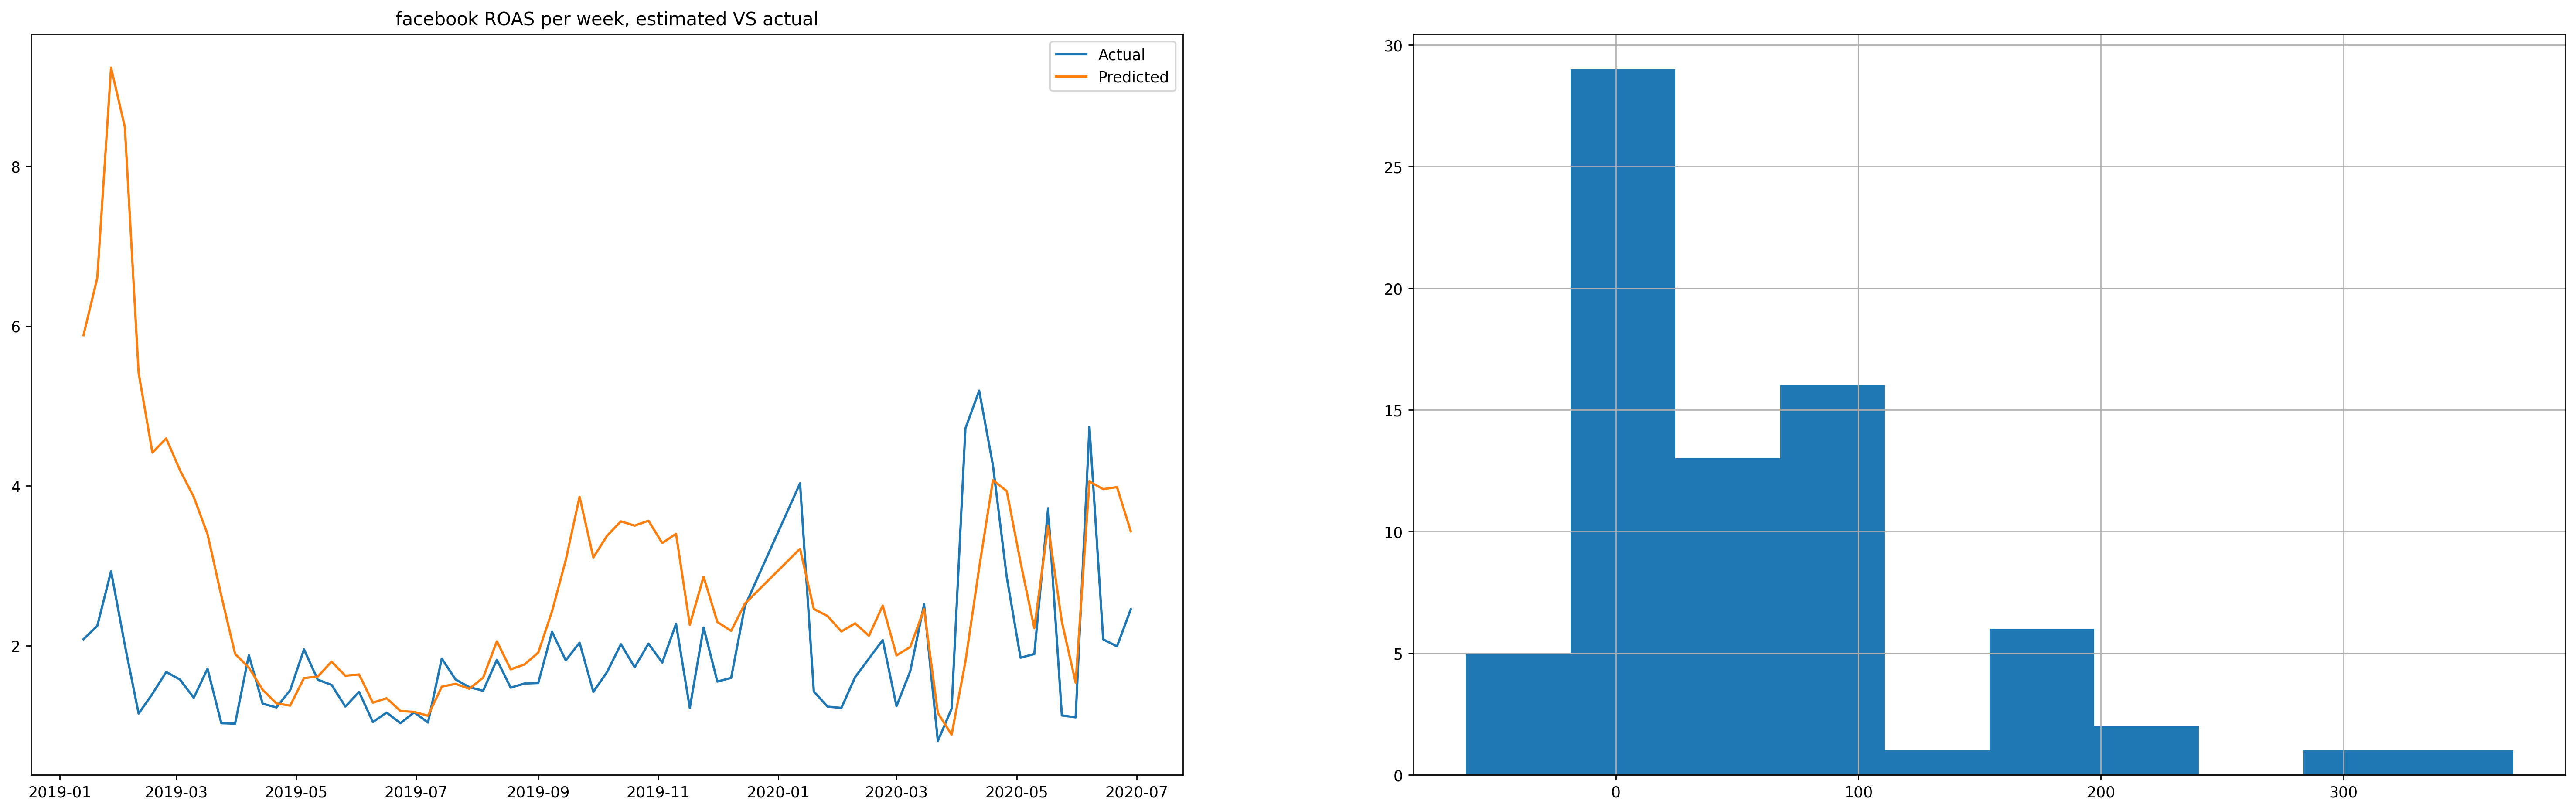

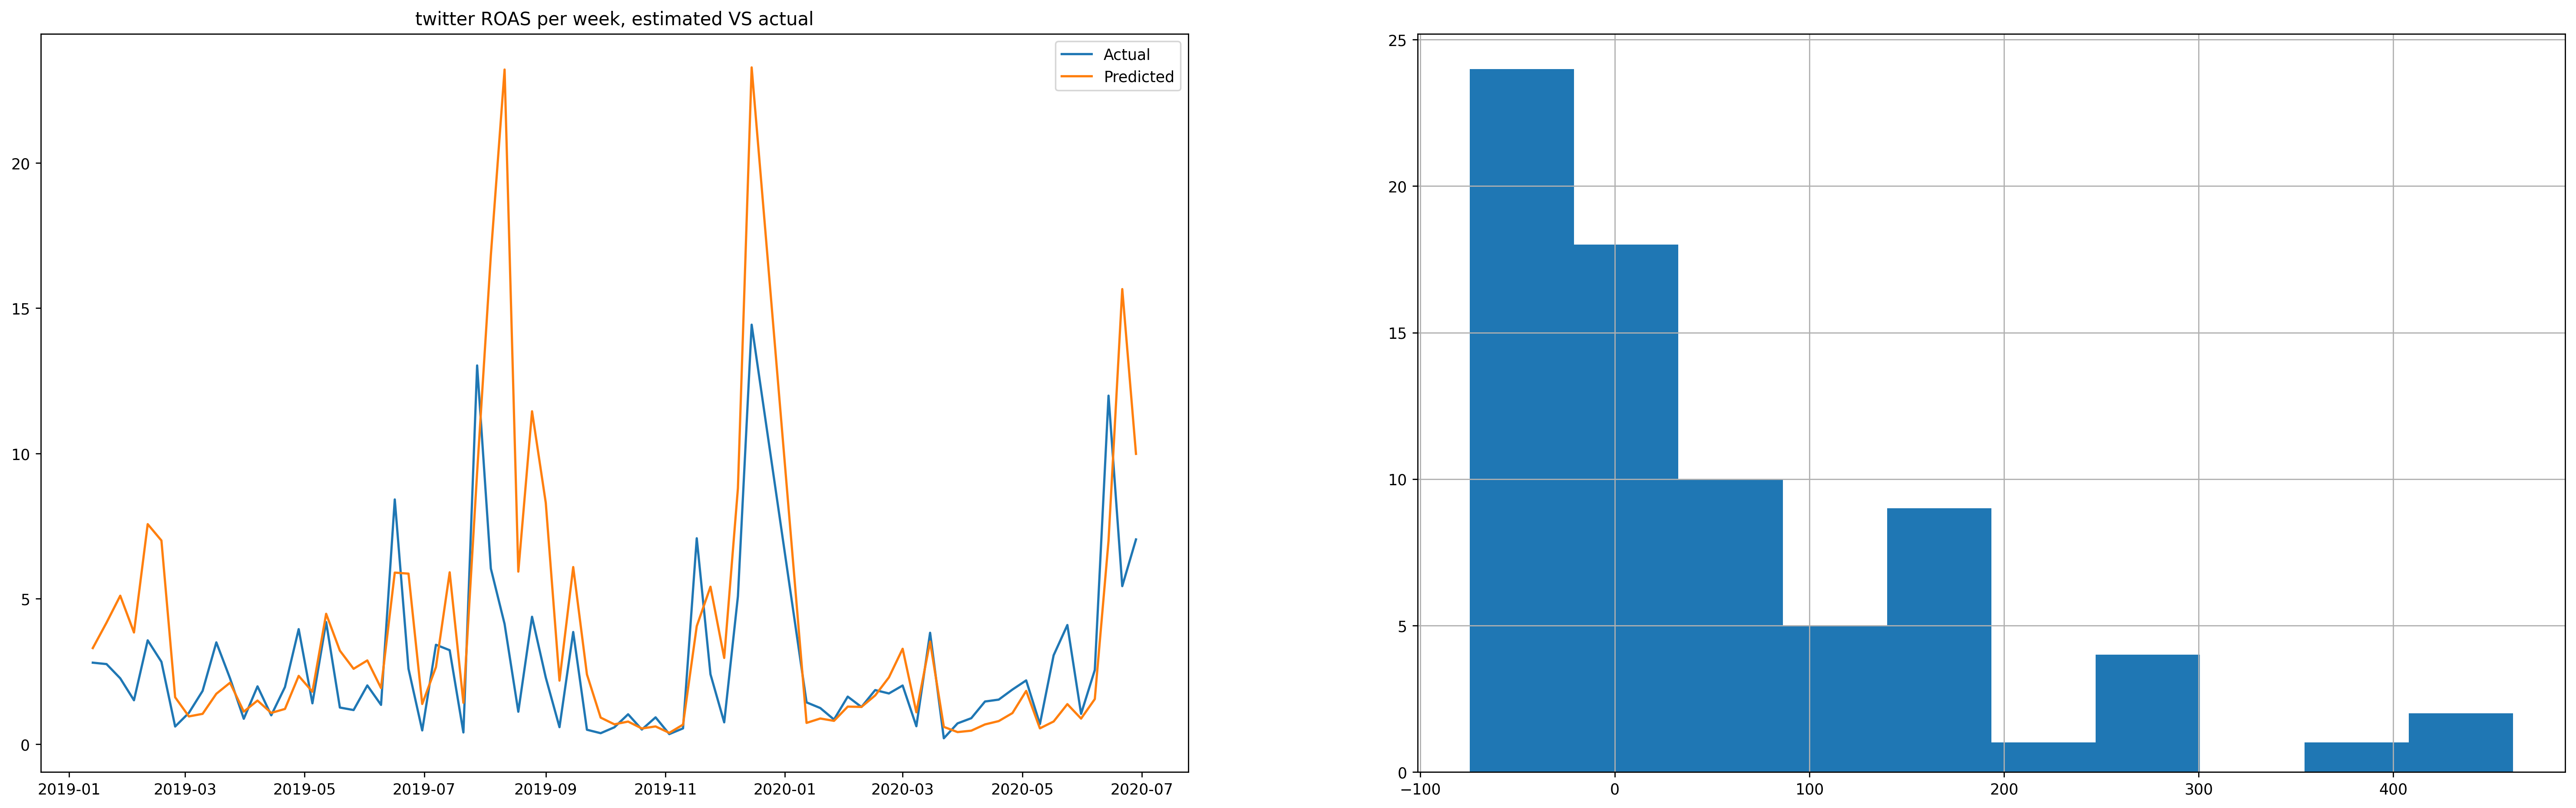

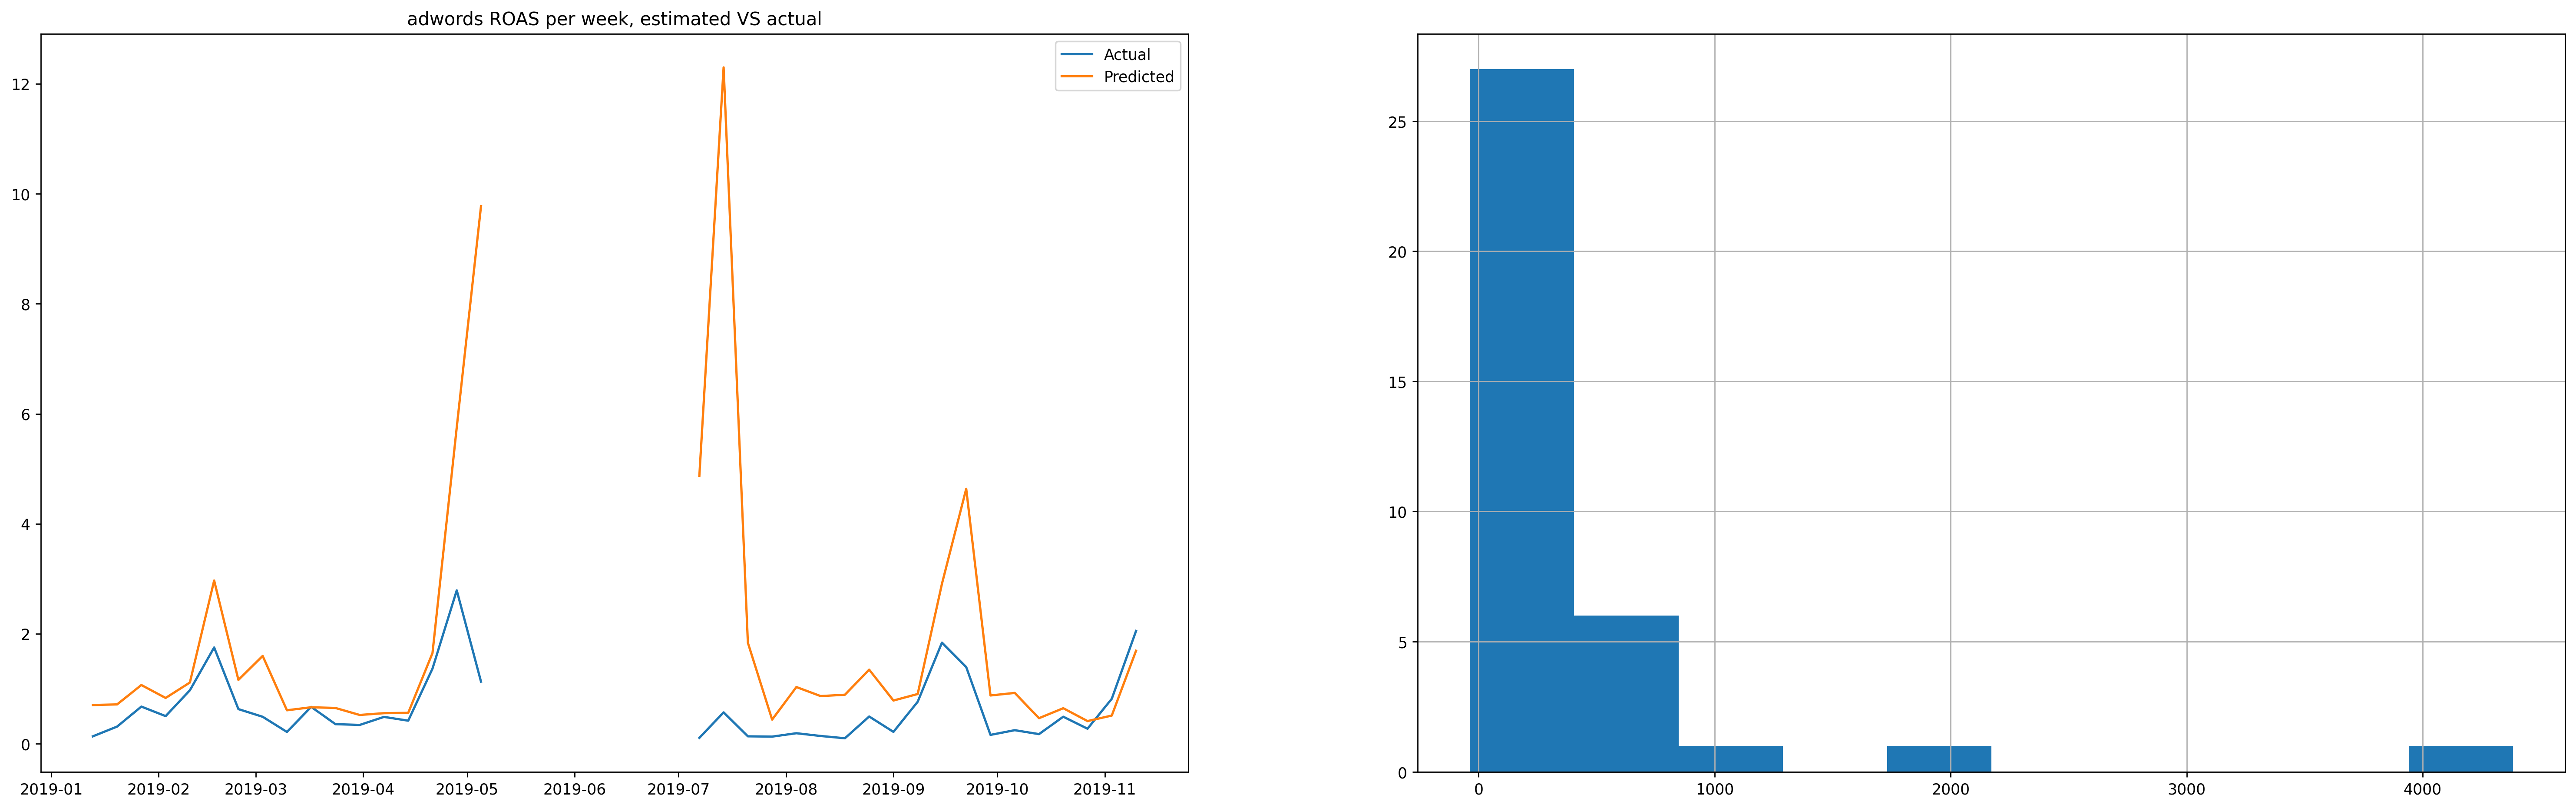

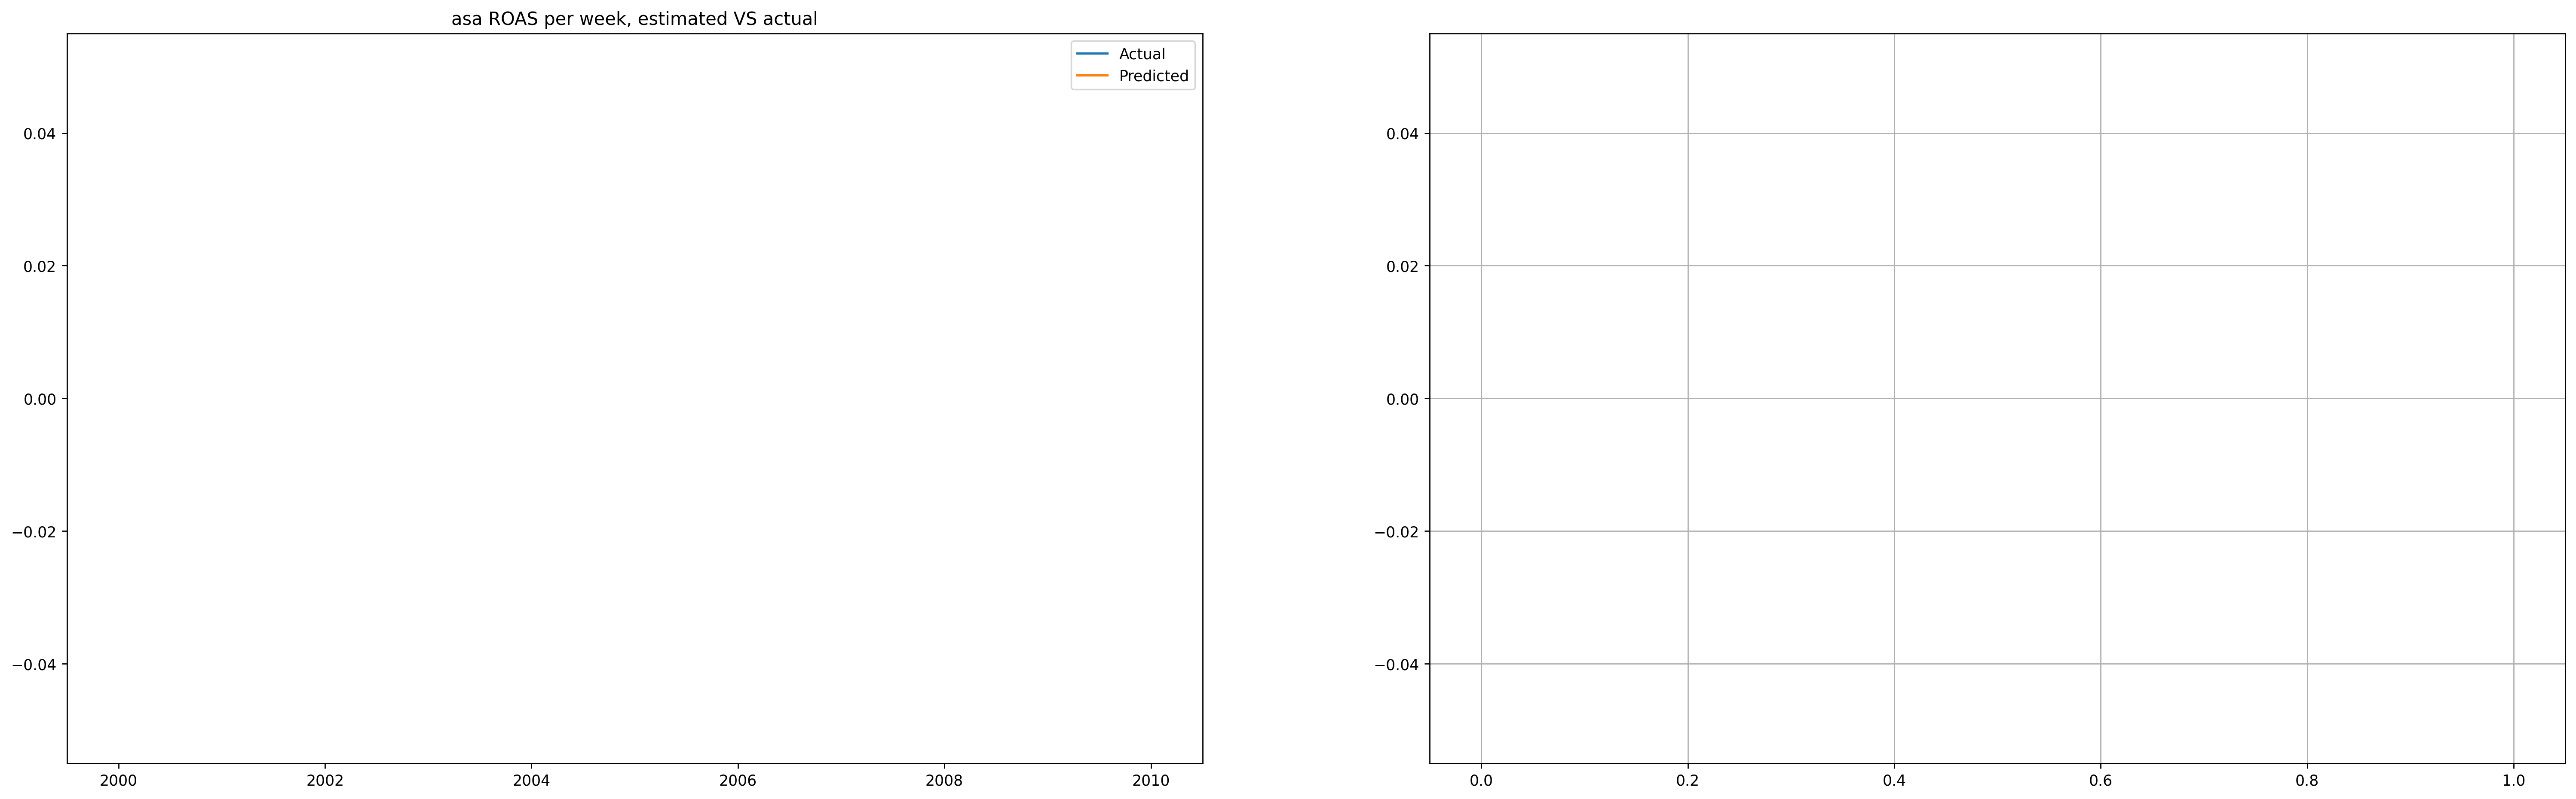

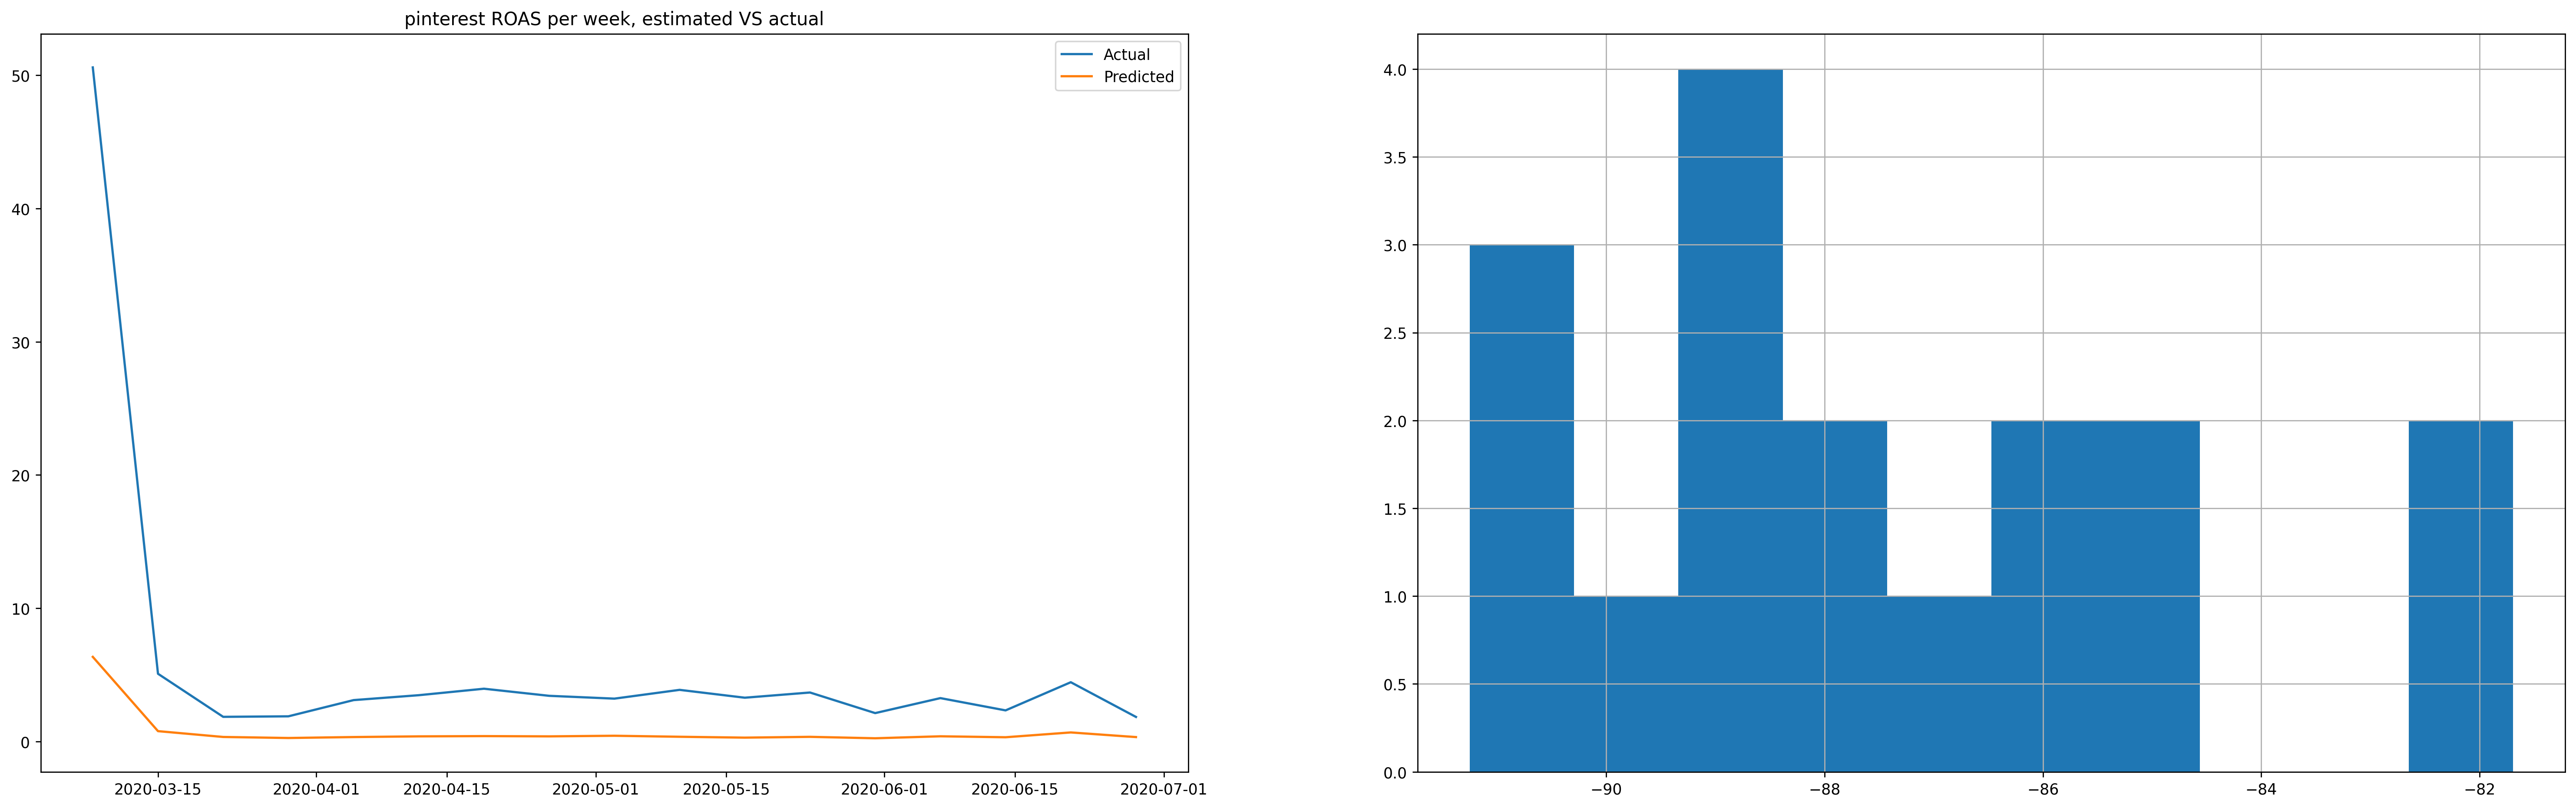

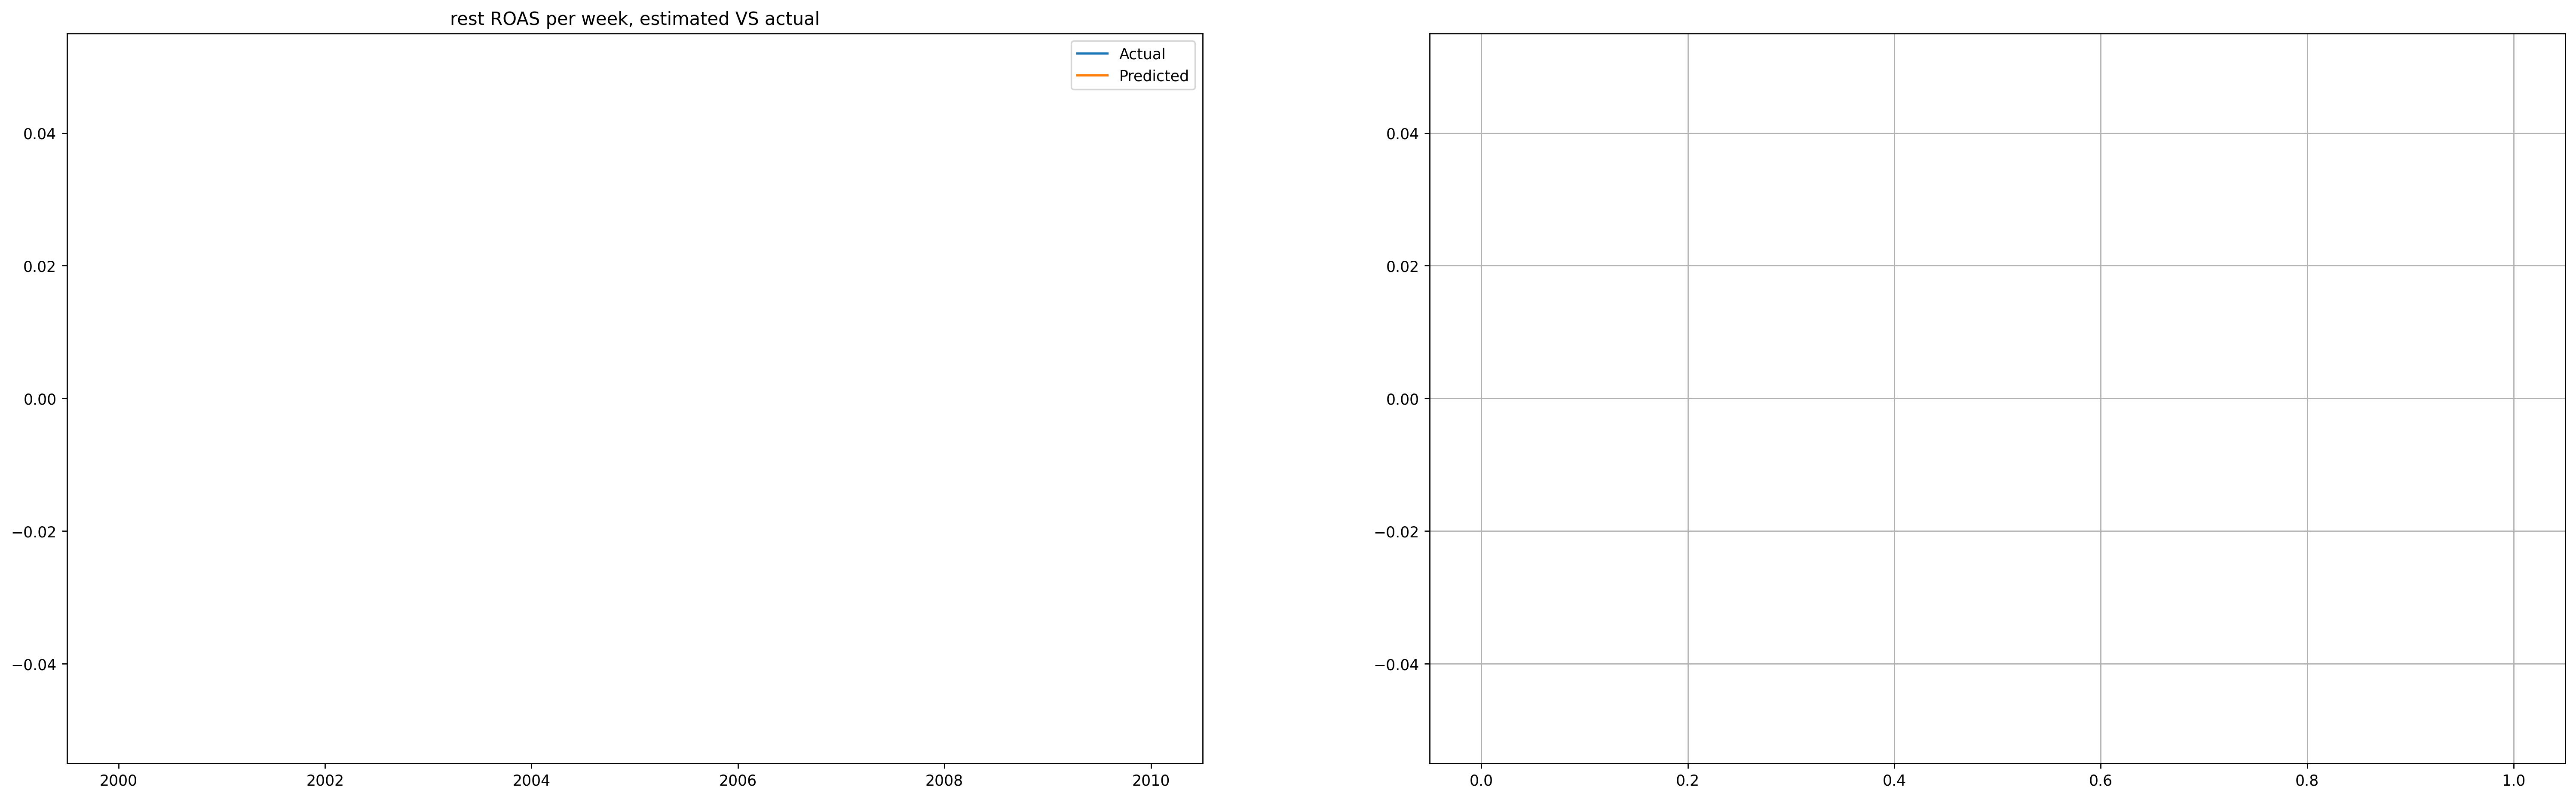

In [44]:
nw = ['facebook', 'twitter', 'adwords', 'asa', 'pinterest', 'rest']
for network in nw:
    plot_evaluation_per_network(network, df_ROAS)